## Connect To Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/DLSSM/"

## Local

In [1]:
root = './'

## Import Packages

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model
from sklearn import metrics

## Data Preparation

#### Load SUBTLEX data

In [3]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel('Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [4]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [5]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] >= 4:
        category = 'HF'
    else:
        category = 'LF'
    return category

#### Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** FastText represention

In [6]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

Adding appropriate encodings for extra information for both words and non-words

In [7]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

Loading elp data and merging them with subtlex data

In [8]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [9]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
30363,rivalries,256,"[-0.058900885, 0.008364026, 0.051338628, 0.004...","[1, 0]",1,2.069985,LF
36246,thong,510,"[0.032776024, -0.00980338, 0.053295445, -0.016...","[1, 0]",1,3.325258,LF
35351,tatbers,0,"[-0.0016447091, -0.019055858, 0.03696055, 0.02...","[0, 1]",0,0.000000,NW
10605,doubtinfly,0,"[-0.009315564, -0.02388003, 0.08181063, -0.001...","[0, 1]",0,0.000000,NW
9324,deliveryman,15,"[0.0055362913, -0.020027094, 0.018790232, -0.0...","[1, 0]",1,2.194924,LF


## Nueral Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 300)               90300     
                                                                 
 dense2 (Dense)              (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense3 (Dense)              (None, 100)               30100     
                                                                 
 dense4 (Dense)              (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense5 (Dense)              (None, 10)                5

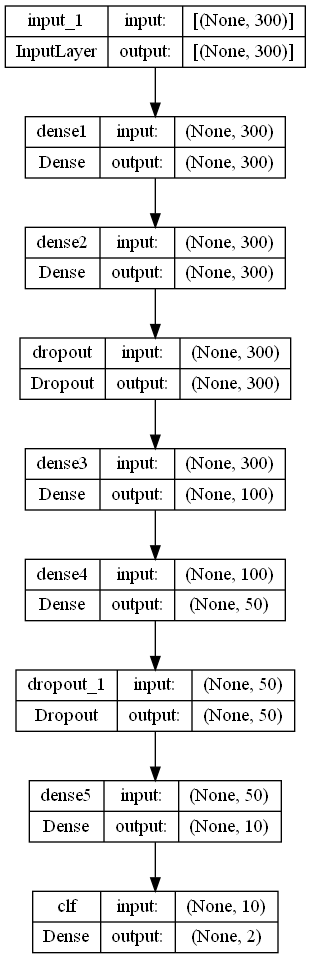

In [10]:
# Sequential Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(300,)))
model.add(layers.Dense(300, activation="relu", name="dense1"))
model.add(layers.Dense(300, activation="relu", name="dense2"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation="relu", name="dense3"))
model.add(layers.Dense(50, activation="relu", name="dense4"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation="relu", name="dense5"))
model.add(layers.Dense(2, activation='softmax', name='clf'))

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='./Plots/FC-RDM/fully_connected_model.png', show_shapes=True)

In [11]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
kf = KFold(n_splits=5, shuffle=True)

In [12]:
checkpoint_filepath = root + '/check_points/fully_connected/FC_Model'

callbacks_list = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )
]

In [13]:
for train_index, test_index in kf.split(elp_df['code']):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(
        x = np.array(list(elp_df['represention']))[train_index],
        y = np.array(list(elp_df['code']))[train_index],
        validation_split=0.2,
        callbacks = callbacks_list,
        epochs=20)
  
    # Generate generalization metrics
    print()
    scores = model.evaluate(np.array(list(elp_df['represention']))[test_index], np.array(list(elp_df['code']))[test_index], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
1487/1487 [==============================] - 13s 7ms/step - loss: 0.0530 - accuracy: 0.9852 - val_loss: 0.0281 - val_accuracy: 0.9905
Epoch 2/20
1487/1487 [==============================] - 12s 8ms/step - loss: 0.0239 - accuracy: 0.9934 - val_loss: 0.0253 - val_accuracy: 0.9915
Epoch 3/20
1487/1487 [==============================] - 14s 9ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0245 - val_accuracy: 0.9933
Epoch 4/20
1487/1487 [==============================] - 13s 9ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.0348 - val_accuracy: 0.9907
Epoch 5/20
1487/1487 [==============================] - 14s 10ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0300 - val_accuracy: 0.9930
Epoch 6/20
1487/1487 [==============================] - 14s 9ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0373 - val_accuracy: 0.9923
Epoch 7/20
1487/1487 [==========

In [14]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.02562808059155941 - Accuracy: 99.37433004379272%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.016497816890478134 - Accuracy: 99.4819700717926%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.009275296702980995 - Accuracy: 99.79142546653748%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.010270027443766594 - Accuracy: 99.72414970397949%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.011468465439975262 - Accuracy: 99.7376024723053%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.62189555168152 (+- 0.1633721003059352)
> Loss: 0.014627937413752078
-------------------

In [15]:
# Load the best model weights.
model.load_weights(checkpoint_filepath)

## Predicted Probabilities on full dataset


In [16]:
full_dataset_predictions = model.predict(np.array(list(elp_df['represention'])))

2323/2323 [==============================] - 6s 3ms/step


#### Classification results

In [17]:
print(metrics.classification_report(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9983    0.9980     33978
           1     0.9986    0.9981    0.9983     40339

    accuracy                         0.9982     74317
   macro avg     0.9982    0.9982    0.9982     74317
weighted avg     0.9982    0.9982    0.9982     74317



In [18]:
acc_score = (metrics.accuracy_score(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.0018030867769151069

#### Confusion Matrix

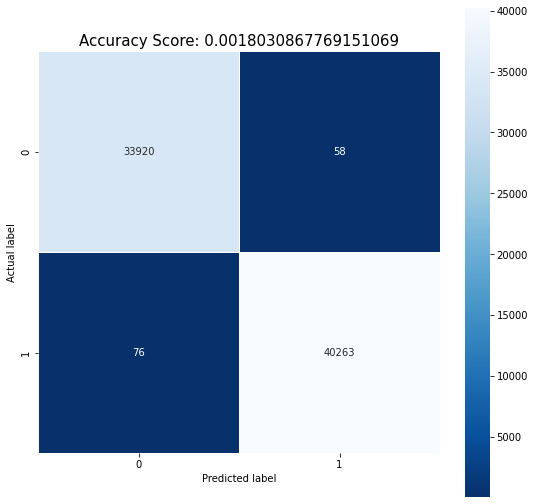

In [19]:
cm = metrics.confusion_matrix(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 15);
plt.savefig('./Plots/FC-RDM/confusion matrix.png')

#### Pridected Probabilites for each words category and non-words

In [20]:
elp_df['word_prob'] = full_dataset_predictions[:,0]
elp_df['nword_prob'] = full_dataset_predictions[:,1]

In [21]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                     nword_prob            \
              mean       std  count  max           min       mean       std   
category                                                                      
HF        0.998771  0.029571   3879  1.0  2.285550e-07   0.001229  0.029571   
LF        0.997803  0.039676  30099  1.0  3.374682e-06   0.002197  0.039676   
NW        0.002917  0.041002  40339  1.0  0.000000e+00   0.997083  0.041002   

                                         
          count       max           min  
category                                 
HF         3879  1.000000  0.000000e+00  
LF        30099  0.999997  2.960857e-32  
NW        40339  1.000000  1.738773e-09

## Save Predicted Probabilities of full dataset


In [22]:
elp_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [23]:
elp_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
30363,rivalries,256,1,2.069985,LF,1.000000,2.862424e-10
36246,thong,510,1,3.325258,LF,1.000000,1.229264e-07
35351,tatbers,0,0,0.000000,NW,0.000128,9.998722e-01
10605,doubtinfly,0,0,0.000000,NW,0.000296,9.997036e-01
9324,deliveryman,15,1,2.194924,LF,1.000000,8.274042e-11
...,...,...,...,...,...,...,...
35140,supremacist,479,1,1.990804,LF,1.000000,9.876521e-09
20952,gadmen,0,0,0.000000,NW,0.000016,9.999835e-01
33300,spiraked,0,0,0.000000,NW,0.000006,9.999938e-01
18715,imtroducing,0,0,0.000000,NW,0.005001,9.949989e-01


In [24]:
elp_df_to_save.to_csv(root+"Datasets/fastText_subtlex_FC.csv", header=0, index=False)